# Adagrad
这个优化算法被称为自适应学习率优化算法，之前讲的随机梯度下降以及动量法对所有的参数都使用的固定的学习率进行参数更新，但是不同的参数梯度可能不一样，所以需要不同的学习率才能比较好的进行训练，但是这个事情又不能很好地被人为操作，所以 Adagrad 便能够帮助我们做这件事。

## Adagrad 算法
Adagrad 的想法非常简答，在每次使用一个 batch size 的数据进行参数更新的时候，我们需要计算所有参数的梯度，那么其想法就是对于每个参数，初始化一个变量 s 为 0，然后每次将该参数的梯度平方求和累加到这个变量 s 上，然后在更新这个参数的时候，学习率就变为

$$
\frac{\eta}{\sqrt{s + \epsilon}}
$$

这里的 $\epsilon$ 是为了数值稳定性而加上的，因为有可能 s 的值为 0，那么 0 出现在分母就会出现无穷大的情况，通常 $\epsilon$ 取 $10^{-10}$，这样不同的参数由于梯度不同，他们对应的 s 大小也就不同，所以上面的公式得到的学习率也就不同，这也就实现了自适应的学习率。

Adagrad 的核心想法就是，如果一个参数的梯度一直都非常大，那么其对应的学习率就变小一点，防止震荡，而一个参数的梯度一直都非常小，那么这个参数的学习率就变大一点，使得其能够更快地更新

Adagrad 也有一些问题，因为 s 不断累加梯度的平方，所以会越来越大，导致学习率在后期会变得较小，导致收敛乏力的情况，可能无法收敛到表较好的结果，当然后面有一个对其的改进，我们之后会讲到

下面我们来实现一下 Adagrad 的算法

In [1]:
def sgd_adagrad(parameters, sqrs, lr):
    eps = 1e-10
    for param, sqr in zip(parameters, sqrs):
        sqr[:] = sqr + param.grad.data ** 2
        div = lr / torch.sqrt(sqr + eps) * param.grad.data
        param.data = param.data - div

In [2]:
import numpy as np
import torch
from torchvision.datasets import MNIST # 导入 pytorch 内置的 mnist 数据
from torch.utils.data import DataLoader
from torch import nn
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
%matplotlib inline

def data_tf(x):
    x = np.array(x, dtype='float32') / 255
    x = (x - 0.5) / 0.5 # 标准化，这个技巧之后会讲到
    x = x.reshape((-1,)) # 拉平
    x = torch.from_numpy(x)
    return x

train_set = MNIST('./data', train=True, transform=data_tf, download=True) # 载入数据集，申明定义的数据变换
test_set = MNIST('./data', train=False, transform=data_tf, download=True)

# 定义 loss 函数
criterion = nn.CrossEntropyLoss()

In [3]:
train_data = DataLoader(train_set, batch_size=64, shuffle=True)
# 使用 Sequential 定义 3 层神经网络
net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)

# 初始化梯度平方项
sqrs = []
for param in net.parameters():
    sqrs.append(torch.zeros_like(param.data))
    
# 开始训练
losses = []
idx = 0
start = time.time() # 记时开始
for e in range(5):
    train_loss = 0
    for im, label in train_data:
        im = Variable(im)
        label = Variable(label)
        # 前向传播
        out = net(im)
        loss = criterion(out, label)
        # 反向传播
        net.zero_grad()
        loss.backward()
        sgd_adagrad(net.parameters(), sqrs, 1e-2) # 学习率设为 0.01
        # 记录误差
        train_loss += loss.data[0]
        if idx % 30 == 0:
            losses.append(loss.data[0])
        idx += 1
    print('epoch: {}, Train Loss: {:.6f}'
          .format(e, train_loss / len(train_data)))
end = time.time() # 计时结束
print('使用时间: {:.5f} s'.format(end - start))

epoch: 0, Train Loss: 0.414422
epoch: 1, Train Loss: 0.266670
epoch: 2, Train Loss: 0.228325
epoch: 3, Train Loss: 0.202912
epoch: 4, Train Loss: 0.185461
使用时间: 70.59813 s


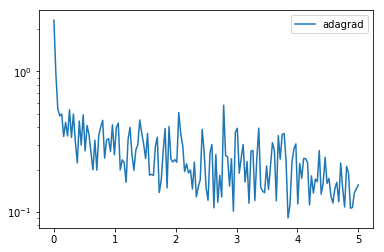

In [4]:
x_axis = np.linspace(0, 5, len(losses), endpoint=True)
plt.semilogy(x_axis, losses, label='adagrad')
plt.legend(loc='best')

可以看到，使用自适应的学习率跑 5 个 epoch 可以得到比随机梯度下降得到更小的 loss，学习率能够自适应地降低，所以能够有着更好的效果

当然 pytorch 也内置了 adagrad 的优化算法，只需要调用 `torch.optim.Adagrad()` 就可以了，下面是例子

In [7]:
train_data = DataLoader(train_set, batch_size=64, shuffle=True)
# 使用 Sequential 定义 3 层神经网络
net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)
 
optimizer = torch.optim.Adagrad(net.parameters(), lr=1e-2)
# 开始训练
losses1 = []
idx = 0

start = time.time() # 记时开始
for e in range(5):
    train_loss = 0
    for im, label in train_data:
        im = Variable(im)
        label = Variable(label)
        # 前向传播
        out = net(im)
        loss = criterion(out, label)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录误差
        train_loss += loss.data[0]
        if idx % 30 == 0: # 30 步记录一次
            losses1.append(loss.data[0])
        idx += 1
    print('epoch: {}, Train Loss: {:.6f}'
          .format(e, train_loss / len(train_data)))
end = time.time() # 计时结束
print('使用时间: {:.5f} s'.format(end - start))

epoch: 0, Train Loss: 0.422448
epoch: 1, Train Loss: 0.271784
epoch: 2, Train Loss: 0.232434
epoch: 3, Train Loss: 0.205277
epoch: 4, Train Loss: 0.186316
使用时间: 68.54367 s


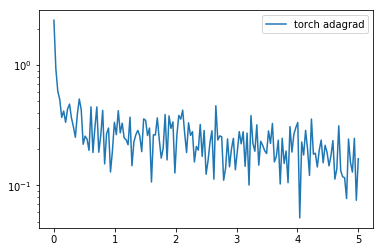

In [8]:
x_axis = np.linspace(0, 5, len(losses), endpoint=True)
plt.semilogy(x_axis, losses1, label='torch adagrad')
plt.legend(loc='best')